# İş Problemi

* Amazon üzerinden satışlarını gerçekleştiren ev tekstili ve günlük giyim odaklı üretimler yapan Kozmos ürünlerine gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını artırmayı hedeflemektedir. Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlencek ve etiketlenen veri ile sınıflandırma modeli oluşturulacaktır

# Veri Seti Hikayesi

* Veri seti belirli bir ürün grubuna ait yapılan yorumları, yorum başlığını, yıldız sayısını ve yapılan yorumu kaç kişinin faydalı bulduğunu belirten değişkenlerden oluşmaktadır.  

>> * **Star:** Ürüne verilen yıldız sayısı 
>> * **HelpFul:** Yorumu faydalı bulan kişi sayısı 
>> * **Title:** Yorum içeriğine verilen başlık, kısa yorum  
>> * **Review:** Ürüne yapılan yorum

In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Görev-1: Metin Ön İşleme

> * **Adım 1:** "amazon.xlsx" verisini okutunuz.

In [2]:
df = pd.read_excel("datasets/amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


> * **Adım 2:** Review değişkeni üzerinde ;
>> * Tüm harfleri küçük harfe çeviriniz.  
>> * Noktalama işaretlerini çıkarınız.  
>> * Yorumlarda bulunan sayısal ifadeleri çıkarınız.  
>> * Bilgi içermeyen kelimeleri (stopwords) veriden çıkarınız.  
>> * 1000'den az geçen kelimeleri veriden çıkarınız.  
>> * Lemmatization işlemini uygulayınız. 

In [3]:
# Küçük harfe çevirelim.

df["Review"] = df["Review"].str.lower()
df.Review

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windows.<br />imag...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i can't believe the qu...
                              ...                        
5606    great product for reasonable money.  delivered...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609    brought out the beauty in kids room. they love...
5610    very cute curtains in my sons room! thick enou...
Name: Review, Length: 5611, dtype: object

In [4]:
# Noktalama işaretlerindne kurtulalım.

df["Review"] = df["Review"].str.replace("[^\w\s]", "")
df.Review

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [5]:
# Sayısal ifadeleri çıkartalım.

df["Review"] = df["Review"].str.replace("\d", "")
df.Review

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [6]:
# stopwords'leri çıkartalım.

sw = stopwords.words("english") # İngilizce stopwords'leri kaydettik.

df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df.Review
# happy with it --> happy

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

In [7]:
# Frekansı 1000'den az kelimeler

temp_df = pd.Series(" ".join(df["Review"]).split()).value_counts() # Bir thresholda göre ayıklama yapacağımız için tüm kelimeleri saydırıyoruz.
print(temp_df[:20])



curtains     1891
love         1312
room         1116
like         1037
beautiful     943
great         921
quality       889
look          879
nice          707
curtain       697
looks         652
picture       640
material      561
light         552
good          535
colors        500
really        447
would         427
perfect       423
well          409
dtype: int64


In [8]:
#drops = temp_df[temp_df <1000] # 1000'den az geçen kelimeler
#df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in x.split() if x not in drops)) # Frekansı 1000'den az olan kelimelerden kurtulduk.
#df.Review # Şu an verimizde boş satırlar var. Çünkü Frekansı 1000'den az olan kelimeleri çıkarttık.

# Frekansa göre kelimeleri ayıkladıktan sonra ortaya çıkan boş satırlardan kurtuldum.
#df["Review"] = df.Review.replace("", np.nan)
#df.dropna(inplace=True)

In [9]:
# Lemmatization işlemi (Kelimeleri köküne indirgeme)

df["Review"] = df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.Review

0                                                   happy
1          good quality material however panel mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria e que sean un poco ma la...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                                color way panel match
5608    great studio complement entire theme studioliv...
5609                         brought beauty kid room love
5610        cute curtain son room thick enough keep light
Name: Review, Length: 5611, dtype: object

# Görev-2: Metin Görselleştirme

> * **Adım 1:** Barplot görselleştirme işlemi için; 
>> * "Review" değişkeninin içerdiği kelimeleri frekanslarını hesaplayınız, tf olarak kaydediniz. 
>> * tf dataframe'inin sütunlarını yeniden adlandırınız: "words", "tf" şeklinde. 
>> * "tf" değişkeninin değeri 500'den çok olanlara göre filtreleme işlemi yaparak barplot ile görselleştirme işlemini tamamlayınız.

In [10]:
# Satır bazında ilgili kelimelerin frekanslarını çıkartıyorum.

tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,happy,196.00
1,good,536.00
2,quality,889.00
3,material,565.00
4,however,78.00


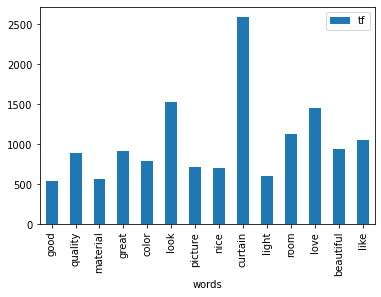

In [11]:
# tf değişkeninin 500'den çok olanlarına barplot uyguluyorum.

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()
# En çok geçen kelimenin "curtain" olduğu çok açık gözüküyor.

> * **Adım 2:** WordCloud görselleştirme işlemi için; 
>> * "Review" değişkeninin içerdiği tüm kelimeleri "text" isminde string olarak kaydediniz. 
>> * WordCloud kullanarak şablon şeklinizi belirleyip kaydediniz. 
>> * Kaydettiğiniz wordcloud'u ilk adımda oluşturduğunuz string ile generate ediniz. 
>> * Görselleştirme adımlarını tamamlayınız. (figure, imshow, axis, show)

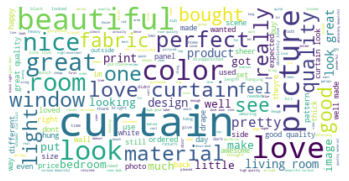

In [12]:
# Tüm datayı tek bir text haline dönüştürdük.
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=230,
                      background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear") # Frekanslara göre kelime boyutları artıyor.
plt.axis("off")
plt.show()

# Görev-3: Duygu Analizi

> * **Adım 1:**  Python içerisindeki NLTK paketinde tanımlanmış olan SentimentIntensityAnalyzer nesnesini oluşturunuz. 

In [13]:
# Metinlerden matematiksel skor çıkarmak için gerekli nesnemiz
sia = SentimentIntensityAnalyzer()

> * **Adım 2:** SentimentIntensityAnalyzer nesnesi ile polarite puanlarının inceleyiniz; 
>> * "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplayınız. 
>> * İncelenen ilk 10 gözlem için compund skorlarına göre filtrelenerek tekrar gözlemleyiniz. 
>> * 10 gözlem için compound skorları 0'dan büyükse "pos" değilse "neg" şeklinde güncelleyiniz. 
>> * "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e
ekleyiniz. 

In [14]:
df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.polarity_score[:10]

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: polarity_score, dtype: float64

In [15]:
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"].value_counts()

pos    4767
neg     844
Name: sentiment_label, dtype: int64

In [16]:
df.head()

,Star,HelpFul,Title,Review,polarity_score,sentiment_label
0,5,0,looks great,happy,0.57,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,0.44,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,0.72,pos
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,0.00,neg
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,0.90,pos


In [17]:
# Oluşturduğumuz "label" kırılımında verilen yıldızların ortalamasına bakalım.

df.groupby("sentiment_label")["Star"].mean()
# Pozitif olarak etiketlediğimiz yorumlara verilen yıldız sayısının daha yüksek olduğunu görüyoruz.

sentiment_label
neg   3.39
pos   4.59
Name: Star, dtype: float64

In [18]:
# Oluşturduğumuz "label" kırılımında faydalı bulunan yorumların sayısının ortalamasına bakalım.

df.groupby("sentiment_label")["HelpFul"].mean()

# Pozitif olarak sınıflandırdığımız yorumları faydalı bulanlar (destekleyenler) oldukça fazla.

sentiment_label
neg   0.82
pos   1.01
Name: HelpFul, dtype: float64

# Görev-4: Makine Öğrenmesi Hazırlık

> * **Adım 1:** Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olarak ayırınız.

In [19]:
# Target değişkenimizi LabelEncoder'dan geçiriyoruz.
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

y = df["sentiment_label"] # Bağımlı Değişkenimiz
X = df["Review"] # Bağımsız Değişkenimiz

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

> * **Adım 2:** Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte; 
>> * TfidfVectorizer kullanarak bir nesne oluşturunuz. 
>> * Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ediniz. 
>> *  Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz. 

In [20]:
# TF-IDF

# word frekans
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer().fit(X_train)
X_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train) # TF-IDF yöntemi ile word frekans
X_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test) # TF-IDF yöntemi ile word frekans

# Görev-5: Modelleme (Lojistik Regresyon)

> * **Adım 1:**  Lojistik regresyon modelini kurarak train dataları ile fit ediniz. 

In [21]:
log_model= LogisticRegression().fit(X_train_tf_idf_word, y_train)

> * **Adım 2:** Kurmuş olduğunuz model ile tahmin işlemleri gerçekleştiriniz; 
>> * Predict fonksiyonu ile test datasını tahmin ederek kaydediniz. 
>> * classification_report ile tahmin sonuçlarınızı raporlayıp gözlemleyiniz. 
>> * cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.

In [22]:
# Test datası üzerinde word frekans tabanlı modelimizin başarısı
y_pred = log_model.predict(X_test_tf_idf_word)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.29      0.44       256
           1       0.89      0.99      0.94      1428

    accuracy                           0.89      1684
   macro avg       0.90      0.64      0.69      1684
weighted avg       0.89      0.89      0.86      1684



In [23]:
# Train datası için cross validation

cross_val_score(log_model,
                X_train_tf_idf_word,
                y_train,
                scoring="accuracy",
                cv=5).mean()

0.8790421549083485

In [24]:
# Test datası için cross validation
cross_val_score(log_model,
                X_test_tf_idf_word,
                y_test,
                scoring="accuracy",
                cv=5).mean()

0.8598558711318354

> * **Adım 3:** Veride bulunan yorumlardan rastgele seçerek modele sorulması; 
>> * sample fonksiyonu ile "Review" değişkeni içerisinden örneklem seçierek yeni bir değere atayınız. 
>> * Elde ettiğiniz örneklemi modelin tahmin edebilmesi için CountVectorizer ile vektörleştiriniz. 
>> * Vektörleştirdiğiniz örneklemi fit ve transform işlemlerini yaparak kaydediniz. 
>> * Kurmuş olduğunuz modele örneklemi vererek tahmin sonucunu kaydediniz. 
>> * Örneklemi ve tahmin sonucunu ekrana yazdırınız.

In [25]:
# Verimizden random bir Review seçiyoruz.
random_review = pd.Series(df["Review"].sample(1).values)


# Gelen ham yorumu daha önce yaptığımız işlemlerden geçirmeyi unutmamalıyız!!!!
random_review = TfidfVectorizer().fit(X_train).transform(random_review)

print(log_model.predict(random_review))


[1]


# Görev-6: Modelleme (Random Forest)

> * **Adım 1:** Random Forest modeli ile tahmin sonuçlarının gözlenmesi; 
>> * RandomForestClassifier modelini kurup fit ediniz. 
>> * Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız. 
>> * Lojistik regresyon modeli ile sonuçları karşılaştırınız. 

In [26]:
# TF-IDF Word-Level

rf_model = RandomForestClassifier().fit(X_train_tf_idf_word, y_train)

# Train datası için accuracy
cross_val_score(rf_model, 
                X_train_tf_idf_word, 
                y_train, 
                scoring="accuracy",
                cv=5, n_jobs=-1).mean()

0.9116344953890536

In [27]:
# Test datası
cross_val_score(rf_model, 
                X_test_tf_idf_word, 
                y_test, 
                scoring="accuracy",
                cv=5, n_jobs=-1).mean()

0.8889430549667938

* LogisticRegression, test datası üzerinde accuracy değeri = 0.86 
* RandomForest, test data üzerinde accuracy değeri = 0.89 

* Bu modeller için hiperparametre optimizasyonu yapılabilir. 
* TF-IDF ile ngram frekans yaklaşımı ile bu işlemler tekrar yapılabilir. 
* Rarewords'lerden kurtulma işlemi yapılabilir.